# Models 

In this notebook, we develop the models for the transformed dataset. 

In [38]:
import pandas as pd
import numpy as np
import os
import tqdm
from utilities import Utilities

import warnings
warnings.filterwarnings("ignore")

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# models 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# others
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

from scipy.stats import jarque_bera
from statsmodels.graphics.regressionplots import influence_plot

## Definitions for the notebook

In [2]:
# For local folder
IMAGES_FOLDER = "../notes/images/"
# For Google colab
#IMAGES_FOLDER = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/images/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

utility = Utilities()

%matplotlib inline

## Importing the dataset

In [3]:
# For local folder
location = "../data/"
# For Google colab
#location = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/"

air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p3.csv", index_col = 0)
air_data.weekend = air_data.weekend.astype(int)
air_data = air_data.reset_index().drop(columns="index")
air_data.head()

,year,month,day,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,...,CO_lag24,CO_MA24,O3_lag1,O3_lag2,O3_lag24,O3_MA24,PM10_lag1,PM10_lag2,PM10_lag24,PM10_MA24
0,2011,1,2,1,-22.965,-43.180,3.617,-1.530,-1.128,-0.140,...,-0.763,-0.936,-0.738,-0.543,-1.190,-0.365,0.101,0.078,0.087,0.082
1,2011,1,2,7,-22.898,-43.222,-0.272,-1.513,-0.565,0.560,...,-1.678,-1.232,-0.612,-0.997,-0.724,-0.187,-0.307,-0.967,-1.858,-1.136
2,2011,1,2,3,-22.908,-43.178,3.617,-1.557,-0.720,-0.470,...,-0.634,-0.166,-0.211,-0.717,-0.169,-0.027,-0.677,-0.677,-1.617,-1.141
3,2011,1,2,8,-22.925,-43.233,3.617,-1.909,-0.194,-1.068,...,-0.897,-1.283,-0.267,-0.184,-1.028,0.274,-0.773,-0.583,0.495,-1.061
4,2011,1,2,7,-22.898,-43.222,3.617,-1.658,-0.567,0.548,...,-1.591,-1.206,-1.300,-0.612,-1.099,-0.204,-0.484,-0.307,-0.967,-1.136


## Inverse Power Transformation 

In [4]:
air_data_ = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv", index_col = 0)

gases = ['CO', 'O3', 'PM10']

pt_gases = {key: PowerTransformer(method = 'yeo-johnson', 
                                  standardize=True).fit(air_data_[[key]]) for key in gases}

del air_data_

## Train and Test

In [7]:
df_train = air_data[air_data.train].drop(columns='train')
df_test = air_data[~air_data.train].drop(columns='train')

x_train = df_train.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])
x_test = df_test.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])

## Tijuca station

The chosen station to report more detailed results.

In [8]:
x_train_SP = x_train[x_train.CodNum == 8].drop(columns="CodNum")
x_test_SP = x_test[x_test.CodNum == 8] .drop(columns="CodNum")

y_train_o3 = df_train[df_train.CodNum==8].O3
y_train_co = df_train[df_train.CodNum==8].CO
y_train_pm10 = df_train[df_train.CodNum==8].PM10

y_test_o3 = df_test[df_test.CodNum==8].O3
y_test_co = df_test[df_test.CodNum==8].CO
y_test_pm10 = df_test[df_test.CodNum==8].PM10

del df_train, df_test

## Linear regression

We first start with the ozone. 

In [9]:
x_train_SP_sm = sm.add_constant(x_train_SP)
x_test_SP_sm = sm.add_constant(x_test_SP)

reg = sm.OLS(y_train_o3, x_train_SP_sm)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 1.199e+04
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        00:27:54   Log-Likelihood:                -20194.
No. Observations:               54290   AIC:                         4.044e+04
Df Residuals:                   54263   BIC:                         4.068e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2878      2.546     12.681      0.0

In [10]:
y_pred = res.predict(x_test_SP_sm)

y_train_pred = res.predict(x_train_SP_sm)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "simple_linear_regression", {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8517668189656552
MAE train set: 0.25780109884853836
RMSE train set: 0.350999594200755
R2 test set: 0.8370700290526956
MAE test set: 0.22463310207015727
RMSE test set: 0.3039159513047826


Let's look at the residuals

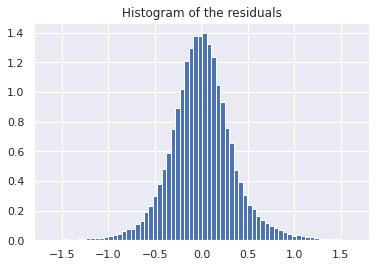

In [11]:
residuals = y_train_pred - y_train_o3
plt.hist(residuals, bins = 100, density = True)
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.savefig(IMAGES_FOLDER+"histogram_residuals_slr.eps", bbox_inches = 'tight')
plt.show()

In [12]:
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: 0.22558431082476935
Kurt: 2.8041868083755976
Jarque-Bera: Jarque_beraResult(statistic=18243.56064834909, pvalue=0.0)


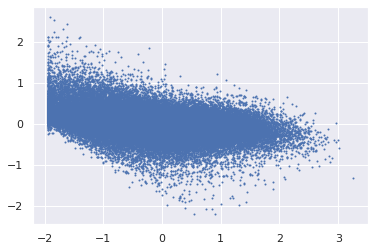

In [13]:
plt.scatter(y_train_o3, residuals, s=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


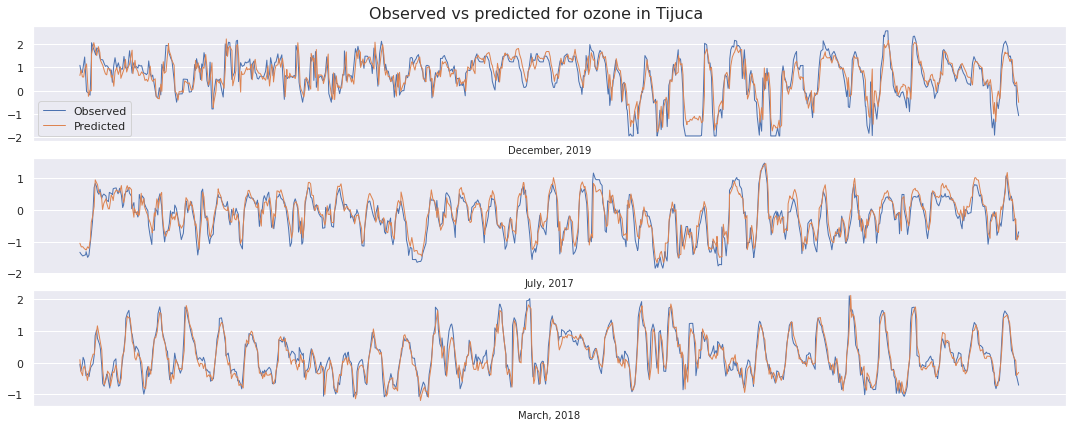

In [39]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Support vector machine

In [ ]:
x_train_AV = x_train[x_train.CodNum==1]
x_test_AV =  x_test[x_test.CodNum==1]

y_train_AV = df_train[df_train.CodNum==1]['O3']
y_test_AV = df_test[df_test.CodNum==1]['O3']

In [ ]:
regr = make_pipeline(StandardScaler(), 
                     LinearSVR(random_state=0, tol=1e-5, max_iter = 100000))

regr.fit(x_train_AV, y_train_AV)

In [ ]:
y_pred_train_AV = regr.predict(x_train_AV)
y_pred_AV = regr.predict(x_test_AV)

In [ ]:
print("R2 train set: {}".format(r2_score(y_train_AV, y_pred_train_AV)))
print("MAE train set: {}".format(mean_absolute_error(y_train_AV, y_pred_train_AV)))
print("RMSE train set: {}".format(mean_squared_error(y_train_AV, y_pred_train_AV, squared = False)))

print("R2 test set: {}".format(r2_score(y_test_AV, y_pred_AV)))
print("MAE test set: {}".format(mean_absolute_error(y_test_AV, y_pred_AV)))
print("RMSE test set: {}".format(mean_squared_error(y_test_AV, y_pred_AV, squared = False)))

In [ ]:
air_data.groupby("CodNum").mean()[["O3", "PM10", "CO"]]

In [ ]:
air_data[air_data.year==2011].CodNum.unique()

In [ ]:
a = {0: 'a'}
len(a.keys())